# **Differential Drive Kinematic Control (Orientation Included)**

This notebook **extends** the Siegwart et al. approach so that the robot also aligns with the **final orientation** \(\theta_g\). We define:

- $\rho = \sqrt{(x_g - x)^2 + (y_g - y)^2}$ (distance to goal)
- $\alpha = -\theta + \mathrm{atan2}(y_g - y,\; x_g - x)$  (heading error toward goal)
- $\beta = \theta_g - \theta - \alpha$  (final heading alignment)

The **control** is:

$v = k_\rho * \rho,$
$\omega = k_\alpha * \alpha + k_\beta * \beta$.

With a **nonzero** \(k_\beta\), the robot will attempt to match \(\theta_g\) as \(\rho\to 0\).

## Outline:
1. Kinematic Model & Setup
2. Defining \(\rho, \alpha, \beta\)
3. Controller (Siegwart) with final orientation
4. Simulation & Visualization


## 1. Imports & Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, sin, cos, sqrt, pi
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

## 2. Kinematic Model & Wrapping Angles

In [ ]:
def wrap_angle(angle):
    """
    TODO: Wrap 'angle' into the range (-pi, pi].
    HINT:
      - While angle is greater than pi, subtract 2*pi
      - While angle is <= -pi, add 2*pi
    """
    # YOUR CODE HERE
    while angle > pi:
      angle -= 2 * pi
    while angle <= -pi:
      angle += 2 * pi
    return angle


def diff_drive_sim(
    x0, y0, th0,  # initial pose
    xg, yg, thg,  # goal pose
    k_rho,
    k_alpha,
    k_beta,
    dt=0.05,
    max_steps=1000
):
    """
    Simulate differential drive with final orientation.
    - x0, y0, th0 : initial state
    - xg, yg, thg : goal state
    - k_rho, k_alpha, k_beta : control gains
    - dt : integration time step
    - max_steps: safety limit on simulation steps
    """
    x = x0
    y = y0
    th = th0
    traj = np.empty((0, 3))

    """
    Simulate a differential-drive robot that must also align
    to a final orientation 'thg'.

    TODO tasks:
    1) At each step:
       - Compute dx, dy, and distance 'rho' to goal.
       - If rho < 0.01, check if orientation error is also small enough.
         If so, break the loop.
    2) Compute alpha = wrap_angle( -th + atan2(dy, dx) )
    3) Compute beta = wrap_angle( (thg - th) - alpha )
       (Based on the textbook approach.)
    4) Linear velocity v = k_rho * rho
       Angular velocity w = k_alpha * alpha + k_beta * beta
    5) Update x, y, th using Euler integration.
       x += v*cos(th)*dt, y += v*sin(th)*dt, th += w*dt
       And wrap the 'th' angle too!
    """

    x = x0
    y = y0
    th = th0

    # We collect trajectory for plotting/animation
    trajectory = np.array([[x, y, th]])
    traj = np.vstack((traj, trajectory))

    for _ in range(max_steps):
        # YOUR CODE HERE
        # 1) compute dx, dy, rho

        dx = xg - x
        dy = yg - y
        rho = sqrt(dx**2 + dy**2)
        print(rho)

        # 2) check if close enough -> break

        if rho < 0.01:
          break

        # 3) compute alpha, beta

        alpha = wrap_angle(atan2(dy, dx) - th)
        beta = wrap_angle(thg - th - alpha)

        # 4) compute v, w
        v = k_rho * rho
        w = k_alpha * alpha + k_beta * beta

        # 5) Euler integration + wrap angle
        x += v*cos(th)*dt
        y += v*sin(th)*dt
        th += w*dt
        th = wrap_angle(th)


        trajectory = np.array([[x, y, th]])
        traj = np.vstack((traj, trajectory))

        # debugging
        # print(traj)


    return np.array(traj)


## 3. Run a Sample Simulation
Let's start at `(0, 0, 0)` and go to `(5, 3, π/2)`.

In [ ]:
x0, y0, th0 = 0.0, 0.0, 0.0
xg, yg, thg = 5.0, 3.0, np.pi/2

# Gains. We make k_beta nonzero to ensure final orientation.
k_rho = 0.5      # move toward the goal
k_alpha = 1.5    # turn toward the goal
k_beta  = -0.6   # align with final orientation (usually negative!)

trajectory = diff_drive_sim(
    x0, y0, th0,
    xg, yg, thg,
    k_rho=k_rho,
    k_alpha=k_alpha,
    k_beta=k_beta,
    dt=0.05,
    max_steps=1000
)
trajectory[-1]

5.830951894845301
5.706444779921092
5.584861252908251
5.46608589566493
5.350010280211499
5.2365326200887266
5.125557420420719
5.01699513031981
4.910761800556552
4.806778748813313
4.704972234329769
4.60527314331956
4.507616686178056
4.411942107201375
4.318192407287997
4.226314079888781
4.136256860302478
4.047973488276389
3.9614194837607544
3.8765529355766235
3.793334302686992
3.7117262277066594
3.6316933622451715
3.5532022036471096
3.476220942673044
3.40071932165108
3.3266685026218212
3.2540409449975867
3.1828102922589063
3.1129512672169035
3.0444395753784774
2.977251815961633
2.9113654001204434
2.846758475952544
2.7834098598764085
2.721298973980731
2.6604057889637187
2.6007107722958773
2.542194841255751
2.4848393205039234
2.4286259038763376
2.373536620093512
2.3195538020974897
2.2666600597432645
2.2148382555860104
2.1640714835195496
2.1143430500352296
2.065636457883639
2.0179353919343854
1.9712237070414955
1.9254854177338507
1.8807046895614428
1.8368658319391455
1.793953292340127
1.751

array([5.00001827, 2.9900937 , 1.57369934])

## 4. Plot the Robot Path

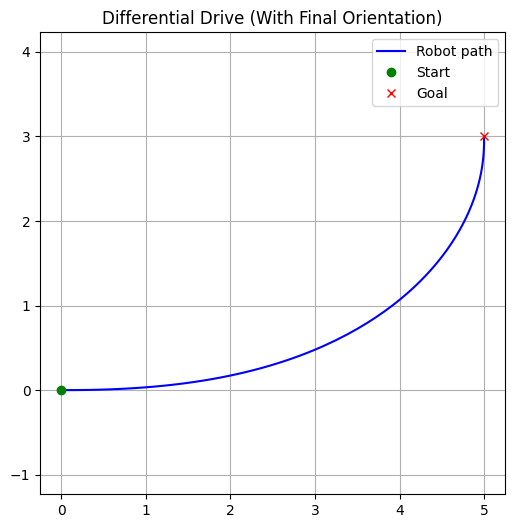

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(trajectory[:,0], trajectory[:,1], 'b-', label='Robot path')
plt.plot(x0, y0, 'go', label='Start')
plt.plot(xg, yg, 'rx', label='Goal')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.title('Differential Drive (With Final Orientation)')
plt.show()

## 5. Animate with Orientation
We'll draw an arrow for the heading at each frame. The arrow direction reflects the current orientation. We want to see if the robot points to the final heading `(theta_g)` near the end.

In [ ]:
def animate_trajectory(traj, xg, yg):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.grid(True)

    xs = traj[:,0]
    ys = traj[:,1]
    ths= traj[:,2]
    margin = 1.0
    x_min, x_max = min(xs)-margin, max(xs)+margin
    y_min, y_max = min(ys)-margin, max(ys)+margin
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.plot(xs, ys, 'b--', alpha=0.3, label='Path preview')
    ax.plot(xs[0], ys[0], 'go', label='Start')
    ax.plot(xg, yg, 'rx', label='Goal')
    ax.legend()
    ax.set_title('Diff Drive Animation (Orientation)')

    robot_body, = ax.plot([], [], 'bo')
    heading_line, = ax.plot([], [], 'r-', lw=2)

    def init():
        robot_body.set_data([], [])
        heading_line.set_data([], [])
        return robot_body, heading_line

    def update(frame):
        x = xs[frame]
        y = ys[frame]
        th= ths[frame]
        robot_body.set_data([x],[y])

        line_len = 0.6
        x_head = x + line_len*np.cos(th)
        y_head = y + line_len*np.sin(th)
        heading_line.set_data([x, x_head],[y, y_head])
        return robot_body, heading_line

    ani = animation.FuncAnimation(fig,
        update,
        frames=len(traj),
        init_func=init,
        blit=True,
        interval=50
    )
    return ani

## 6. Display the Animation
We convert the matplotlib animation to HTML for inline display.

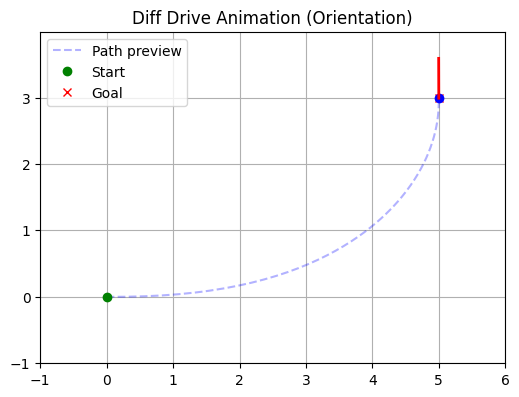

In [ ]:
ani = animate_trajectory(trajectory, xg, yg)
HTML(ani.to_jshtml())

## 7. Observations
With nonzero `k_beta`, the robot attempts to align to `theta_g` after approaching the goal.
Feel free to adjust `(k_rho, k_alpha, k_beta)` to see how it changes the path and final orientation.
